In [18]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Import your ACCEnv
from acc_env import ACCEnv  # make sure acc_env.py is in the same folder

# Folder to save into
LOGDIR = "ppo_acc_attack"
os.makedirs(LOGDIR, exist_ok=True)

# 1) Make training env
def make_env(seed=42):
    def _thunk():
        return ACCEnv(brake_profile=False, normalize_obs=True, seed=seed)
    return _thunk

base_env = DummyVecEnv([make_env()])
train_env = VecNormalize(base_env, norm_obs=True, norm_reward=True, clip_obs=1.0)

# 2) Train PPO
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=50_000)  # increase timesteps for better performance

# 3) Save PPO model + VecNormalize stats
model.save(os.path.join(LOGDIR, "ppo_acc"))
train_env.save(os.path.join(LOGDIR, "vecnormalize.pkl"))

print("✅ Model and VecNormalize saved to", LOGDIR)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1678 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1198         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0056027398 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.0195       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.67         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00252     |
|    std                  | 1.02         |
|    value_loss           | 3.62         |

In [19]:
import os, sys, pprint

# Use the folder you saved into during training
proj_root = os.path.abspath('ppo_acc_attack')

# Ensure path is importable
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

print('Project root:', proj_root)
print('Files:')
print('\n'.join(sorted(os.listdir(proj_root))))


Project root: /Users/lucylikesphotography/Documents/GitHub/PPO-and-Adversarial-Attack/PPO and Adversarial Attack/ppo_acc_attack
Files:
ppo_acc.zip
vecnormalize.pkl


In [20]:
# Convert attacks.ipynb -> attacks.py, fix misplaced "from __future__" imports, then import classes

import os, sys, subprocess, importlib

module_stem = "attacks"
ipynb = f"{module_stem}.ipynb"
py    = f"{module_stem}.py"

# 1) Convert notebook to .py if needed
if os.path.exists(ipynb):
    print(f"Converting {ipynb} -> {py} ...")
    subprocess.run(["jupyter", "nbconvert", "--to", "python", ipynb], check=True)

# 2) Ensure any "from __future__ ..." lines are at the very top of the file
if os.path.exists(py):
    with open(py, "r", encoding="utf-8") as f:
        lines = f.readlines()

    future_idxs = [i for i, l in enumerate(lines) if l.strip().startswith("from __future__")]
    if future_idxs:
        future_lines = [lines[i] for i in future_idxs]
        other_lines  = [l for i, l in enumerate(lines) if i not in future_idxs]
        # Only rewrite if futures aren't already at the top in order
        needs_rewrite = any(i != idx for i, idx in enumerate(future_idxs))
        if needs_rewrite or future_idxs[0] != 0:
            with open(py, "w", encoding="utf-8") as f:
                f.writelines(future_lines + other_lines)
            print("Fixed attacks.py: moved __future__ imports to the top")

# 3) Make sure current directory is importable
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

# 4) Import classes
attacks_mod = importlib.import_module(module_stem)
importlib.reload(attacks_mod)
FGSMAttack = getattr(attacks_mod, "FGSMAttack")
OIAttack   = getattr(attacks_mod, "OIAttack")

print("✅ Imports OK: FGSMAttack, OIAttack ready to use")


Converting attacks.ipynb -> attacks.py ...


[NbConvertApp] Converting notebook attacks.ipynb to python


Fixed attacks.py: moved __future__ imports to the top
Imported ACCEnv from acc_env.py
Train env created. obs_space: Box(-1.0, 1.0, (3,), float32) act_space: Box(-3.5, 2.0, (1,), float32)
Using cpu device
Logging to runs/ppo_baseline


[NbConvertApp] Writing 12255 bytes to attacks.py


Starting training for 200000 timesteps ...
-----------------------------
| time/              |      |
|    fps             | 1595 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1226         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0038024038 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.165        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.62         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00378     |
|    std                  | 0.994        |
|    value_loss 

In [21]:
# Environment factory (vectorized-friendly)

def make_env(brake_profile=False, normalize_obs=True, seed=0):
    def _thunk():
        return ACCEnv(brake_profile=brake_profile, normalize_obs=normalize_obs, seed=seed)
    return _thunk

# Quick smoke test
env = make_env(brake_profile=True, normalize_obs=True)()
obs, info = env.reset()
print('Initial observation:', obs)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)


Initial observation: [-0.6966945  -0.01601057  0.02134743]
Observation space: Box(-1.0, 1.0, (3,), float32)
Action space: Box(-3.5, 2.0, (1,), float32)


In [22]:
# Training cell - adjust TOTAL_STEPS if you want a fast demo
from stable_baselines3.common.logger import configure

TOTAL_STEPS = 200_000  # paper suggests >200k; change to 10_000 for quick tests
LOGDIR = 'runs/ppo_demo'

os.makedirs(LOGDIR, exist_ok=True)

# Create VecNormalize-wrapped env (single-threaded for simplicity)
env = DummyVecEnv([make_env(brake_profile=False, normalize_obs=True)])
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=1.0)

model = PPO('MlpPolicy', env, verbose=1, seed=0,
            n_steps=1024, batch_size=128, learning_rate=3e-4, gamma=0.99,
            gae_lambda=0.95, clip_range=0.2, ent_coef=0.0)
new_logger = configure(LOGDIR, ['stdout','csv','tensorboard'])
model.set_logger(new_logger)

print('Starting training for', TOTAL_STEPS, 'steps...')
# Uncomment the following lines to actually run training
# model.learn(total_timesteps=TOTAL_STEPS)
# model.save(os.path.join(LOGDIR,'ppo_acc'))
# env.save(os.path.join(LOGDIR,'vecnormalize.pkl'))

print('Training cell prepared (learn call is commented out to avoid long runs).')


Using cpu device
Logging to runs/ppo_demo
Starting training for 200000 steps...
Training cell prepared (learn call is commented out to avoid long runs).


In [23]:
# Evaluation utilities
import numpy as np

def load_model_and_env(logdir: str):
    env = DummyVecEnv([make_env(brake_profile=True, normalize_obs=True)])
    env = VecNormalize.load(os.path.join(logdir, 'vecnormalize.pkl'), env)
    env.training = False
    env.norm_reward = False
    model = PPO.load(os.path.join(logdir, 'ppo_acc'))
    return model, env

def run_episode(model, env, attack=None, eps=0.01, render_traj=False):
    obs = env.reset()[0]
    traj = {k: [] for k in ['Δx','v','a','r']}
    total_r = 0.0
    collisions = 0
    rmse_accum = 0.0
    rmse_count = 0

    # Wrap model with attack if requested
    atk = None
    if attack == 'fgsm':
        atk = FGSMAttack(model, epsilon=eps, device='cpu')
    elif attack == 'oia':
        atk = OIAttack(model, epsilon=eps, device='cpu')

    while True:
        if atk is None:
            action, _ = model.predict(obs, deterministic=True)
            obs_in = obs
        else:
            action, obs_in = atk.act(obs)

        obs, reward, term, trunc, info = env.step(action)
        total_r += reward[0] if isinstance(reward, np.ndarray) else reward
        traj['Δx'].append(info[0]['Δx'] if isinstance(info, list) else info['Δx'])
        traj['v'].append(info[0]['v'] if isinstance(info, list) else info['v'])
        traj['a'].append(info[0]['a'] if isinstance(info, list) else info['a'])
        traj['r'].append(reward[0] if isinstance(reward, np.ndarray) else reward)

        if atk is not None:
            diff = (obs_in - obs)
            rmse_accum += float((diff**2).mean())
            rmse_count += 1

        done = bool(term) or bool(trunc)
        if term:
            collisions = 1
        if done:
            break

    jerk = np.mean(np.abs(np.diff(traj['a']))) if len(traj['a']) > 1 else 0.0
    rmse = np.sqrt(rmse_accum / max(1, rmse_count))
    return {'return': total_r, 'collision': collisions, 'jerk': jerk, 'rmse': rmse, 'traj': traj}

def eval_many(model, env, which: str | None, episodes:int=20, eps=0.01, out_prefix='artifacts'):
    atk = 'none' if which is None else which
    rets, cols, jerks, rmses = [], [], [], []
    sample_traj = None
    for ep in range(episodes):
        res = run_episode(model, env, attack=which, eps=eps)
        rets.append(res['return'])
        cols.append(res['collision'])
        jerks.append(res['jerk'])
        rmses.append(res['rmse'])
        if sample_traj is None:
            sample_traj = res['traj']
    avg = {
        'avg_return': float(np.mean(rets)),
        'collision_rate': float(np.mean(cols)),
        'avg_jerk': float(np.mean(jerks)),
        'avg_rmse': float(np.mean(rmses)),
    }
    os.makedirs(out_prefix, exist_ok=True)
    out_csv = os.path.join(out_prefix, f"metrics_{atk}.csv")
    with open(out_csv, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(['metric','value'])
        for k,v in avg.items():
            w.writerow([k,v])
    if sample_traj is not None:
        plot_traj(sample_traj, f'{atk.upper()} sample episode', os.path.join(out_prefix, f'{atk}_traj.png'))
    print(f"{atk}: {avg}")
    return avg

print('Evaluation functions prepared')


Evaluation functions prepared


In [26]:
import os, sys, math, shlex, subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython

# ---------- robust imports / conversions ----------
def ensure_py(stem):
    if not os.path.exists(f"{stem}.py") and os.path.exists(f"{stem}.ipynb"):
        subprocess.run(["jupyter","nbconvert","--to","python",f"{stem}.ipynb"], check=True)
        # fix misplaced __future__ (nbconvert quirk)
        with open(f"{stem}.py","r",encoding="utf-8") as f: lines=f.readlines()
        fut=[l for l in lines if l.strip().startswith("from __future__")]
        oth=[l for l in lines if l not in fut]
        with open(f"{stem}.py","w",encoding="utf-8") as f: f.writelines(fut+oth)

for mod in ["acc_env","attacks"]:
    ensure_py(mod)
    if os.getcwd() not in sys.path: sys.path.insert(0, os.getcwd())

from acc_env import ACCEnv                         # ACCEnv implements CBF clamp a* = min(a_rl, a_max_safe) per Eq.(5)
from attacks import FGSMAttack, OIAttack           # FGSM: ∇s μθ(s); OIA: ∇s Vϕ(s) on normalized obs

# ---------- sb3 imports ----------
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# ---------- helpers for gym/vecnormalize signatures ----------
def reset_unwrap(env, **kw):
    out = env.reset(**kw)
    if isinstance(out, tuple) and len(out)==2: return out[0]
    return out

def step_unwrap(env, action):
    out = env.step(action)
    if len(out)==5:
        obs, r, term, trunc, info = out
        return obs, r, bool(term), bool(trunc), info
    elif len(out)==4:
        obs, r, done, info = out
        return obs, r, bool(done), False, info
    else:
        raise RuntimeError(f"Unexpected step() return length: {len(out)}")


In [27]:
# ---------- config ----------
LOGDIR   = "ppo_acc_attack"       # change if you saved elsewhere (e.g., "runs/ppo_baseline")
VECPATH  = os.path.join(LOGDIR, "vecnormalize.pkl")
MDLPATH  = os.path.join(LOGDIR, "ppo_acc.zip")
EPISODES = 5
EPS      = 0.01                   # attack budget on normalized obs in [-1,1], per paper

os.makedirs(LOGDIR, exist_ok=True)

def make_env_eval(seed=123, brake_profile=True, normalize_obs=True):
    def _thunk():
        return ACCEnv(brake_profile=brake_profile, normalize_obs=normalize_obs, seed=seed)
    return _thunk

# ---------- load or quick-train so the demo always runs ----------
if os.path.exists(VECPATH) and os.path.exists(MDLPATH):
    base = DummyVecEnv([make_env_eval(123, True, True)])
    env  = VecNormalize.load(VECPATH, base); env.training=False; env.norm_reward=False
    model = PPO.load(MDLPATH, env=env)
    print("Loaded saved PPO+VecNormalize from", LOGDIR)
else:
    print("Saved files not found; quick-training (~8k steps) so demo can run.")
    train_base = DummyVecEnv([make_env_eval(42, False, True)])
    train_env  = VecNormalize(train_base, norm_obs=True, norm_reward=True, clip_obs=1.0)
    model = PPO("MlpPolicy", train_env, verbose=0, seed=42,
                n_steps=512, batch_size=128, learning_rate=3e-4,
                gamma=0.99, gae_lambda=0.95, clip_range=0.2, ent_coef=0.0)
    model.learn(total_timesteps=8_000)
    eval_base = DummyVecEnv([make_env_eval(123, True, True)])
    env = VecNormalize(eval_base, norm_obs=True, norm_reward=False, clip_obs=1.0)
    env.obs_rms = train_env.obs_rms; env.ret_rms = train_env.ret_rms
    env.training=False
    print("Quick-train done; using in-memory model/env.")

Loaded saved PPO+VecNormalize from ppo_acc_attack


In [28]:
# ---------- single-episode runner (applies attacker on observation before predict) ----------
def run_episode(mdl, venv, attacker=None, eps=EPS, max_steps=None):
    obs = reset_unwrap(venv)
    total_r = 0.0
    collided = 0
    traj = {"Δx": [], "v": [], "a": [], "r": []}
    rmse_series, max_series = [], []
    steps = 0
    while True:
        obs_adv = attacker.perturb(obs) if attacker is not None else obs
        action, _ = mdl.predict(obs_adv, deterministic=True)
        obs_next, r, term, trunc, info = step_unwrap(venv, action)

        # stealth metrics
        d = np.asarray(obs_adv) - np.asarray(obs)
        rmse_series.append(float(np.sqrt(np.mean(d**2))))
        max_series.append(float(np.max(np.abs(d))))

        idict = info if isinstance(info, dict) else (info[0] if hasattr(info, "__len__") and len(info) else {})
        traj["Δx"].append(idict.get("Δx", math.nan))
        traj["v"].append(idict.get("v", math.nan))
        traj["a"].append(idict.get("a", math.nan))
        r_scalar = float(r[0]) if hasattr(r, "__len__") else float(r)
        traj["r"].append(r_scalar)
        total_r += r_scalar
        if idict.get("collision", False) or (not math.isnan(traj["Δx"][-1]) and traj["Δx"][-1] <= 0):
            collided = 1

        obs = obs_next
        steps += 1
        if term or trunc or (max_steps is not None and steps >= max_steps):
            break

    jerk = float(np.mean(np.abs(np.diff(traj["a"])))) if len(traj["a"])>1 else 0.0
    return {"return": total_r, "collision": collided, "jerk": jerk,
            "traj": traj, "rmse_series": np.array(rmse_series), "max_series": np.array(max_series)}


In [29]:
# ---------- multi-episode eval ----------
def eval_condition(attacker_cls=None, eps=EPS, episodes=EPISODES):
    rets, cols, jerks = [], [], []
    sample = None
    for i in range(episodes):
        seed = 100 + i
        base = DummyVecEnv([make_env_eval(seed, True, True)])
        venv = None
        if os.path.exists(VECPATH):
            venv = VecNormalize.load(VECPATH, base); venv.training=False; venv.norm_reward=False
        else:
            venv = base
        mdl = PPO.load(MDLPATH, env=venv) if os.path.exists(MDLPATH) else model
        attacker = attacker_cls(mdl, epsilon=eps, device="cpu") if attacker_cls else None
        res = run_episode(mdl, venv, attacker=attacker, eps=eps)
        rets.append(res["return"]); cols.append(res["collision"]); jerks.append(res["jerk"])
        if sample is None: sample = res
    return {
        "avg_return": float(np.mean(rets)),
        "collision_rate": float(np.mean(cols)),
        "avg_jerk": float(np.mean(jerks)),
        "sample": sample
    }

print("Evaluating baseline / FGSM / OIA ...")
baseline = eval_condition(None,        eps=0.0,     episodes=EPISODES)
fgsm     = eval_condition(FGSMAttack,  eps=EPS,     episodes=EPISODES)
oia      = eval_condition(OIAttack,    eps=EPS,     episodes=EPISODES)

print("\nAverages across", EPISODES, "episodes")
print("Baseline :", {k:v for k,v in baseline.items() if k!='sample'})
print("FGSM     :", {k:v for k,v in fgsm.items()     if k!='sample'})
print("OIA      :", {k:v for k,v in oia.items()      if k!='sample'})


Evaluating baseline / FGSM / OIA ...

Averages across 5 episodes
Baseline : {'avg_return': -7079.985054636437, 'collision_rate': 0.0, 'avg_jerk': 0.047535594800834}
FGSM     : {'avg_return': -7077.310609800258, 'collision_rate': 0.0, 'avg_jerk': 0.07023833522015224}
OIA      : {'avg_return': -7086.795811813436, 'collision_rate': 0.0, 'avg_jerk': 0.0477338124940574}


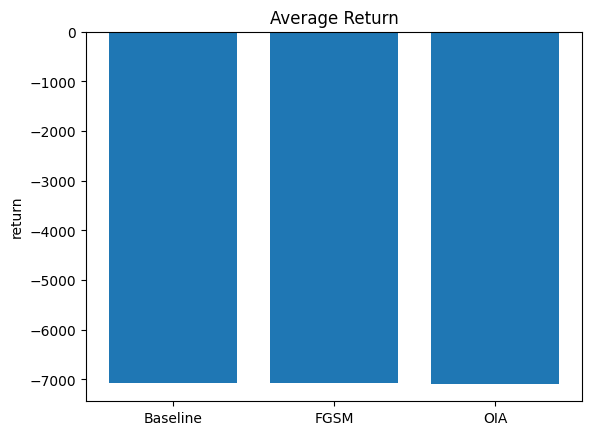

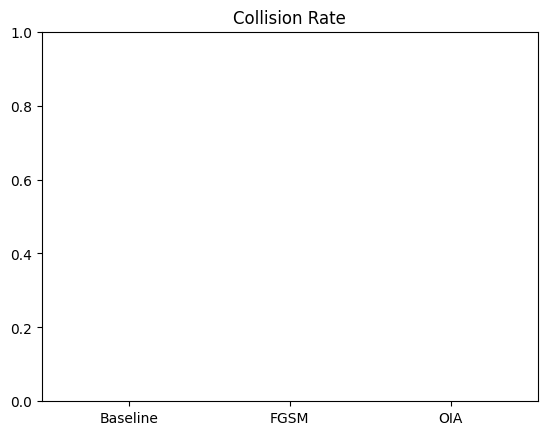

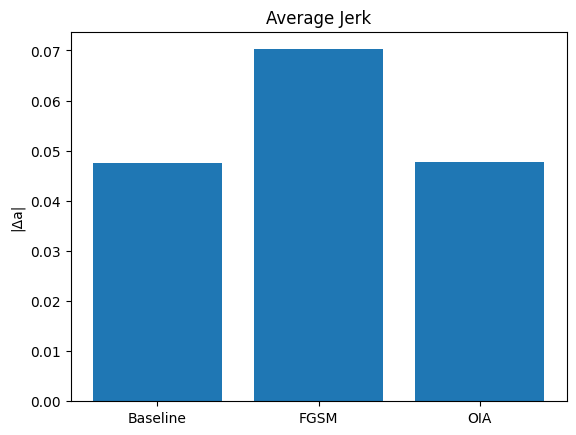

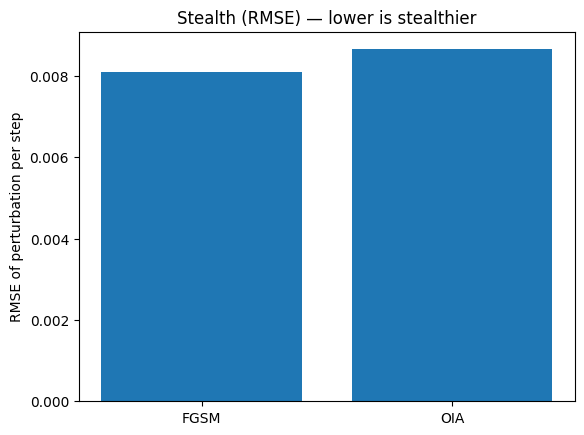

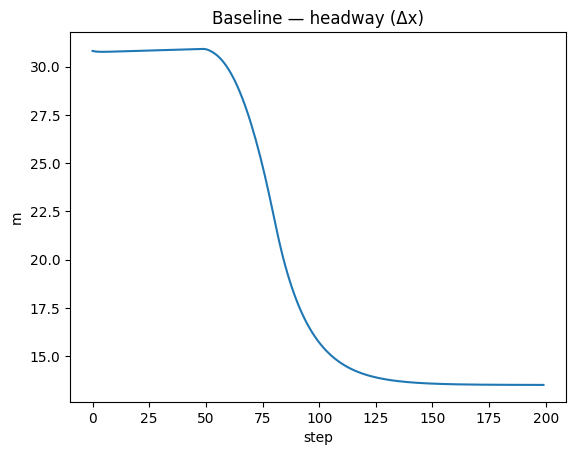

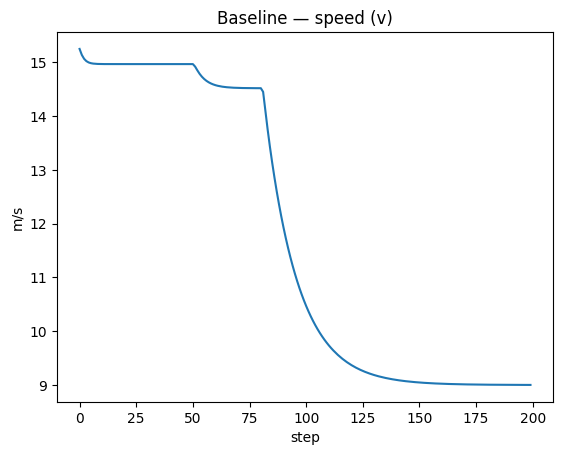

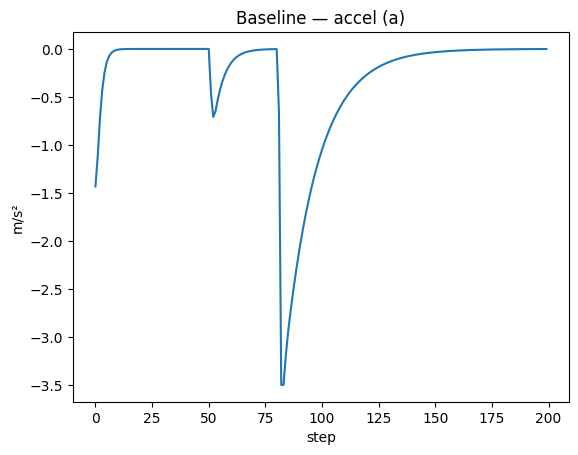

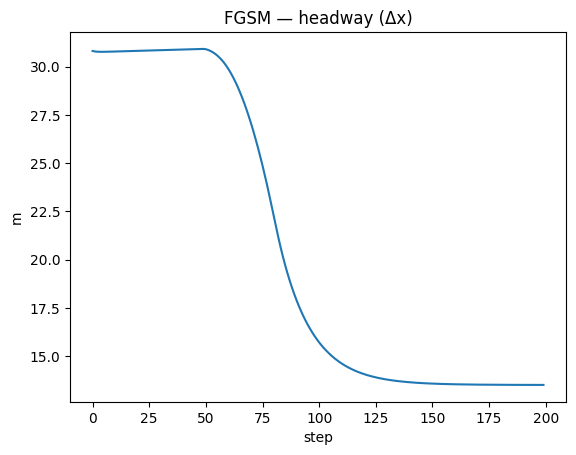

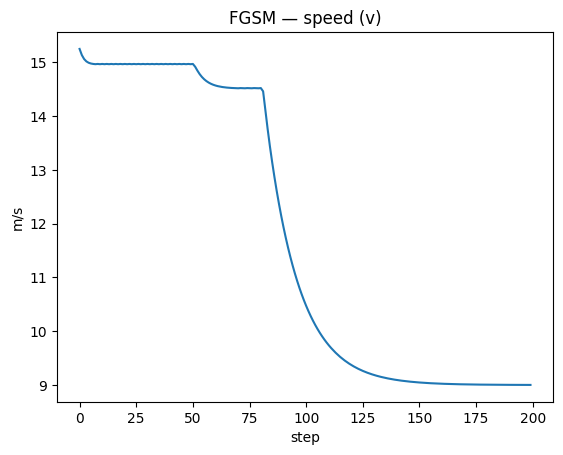

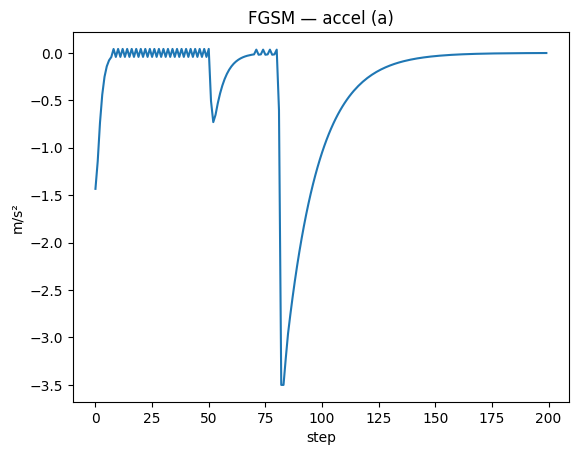

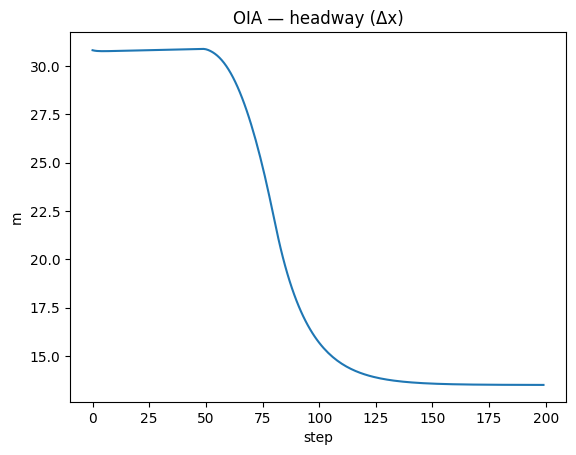

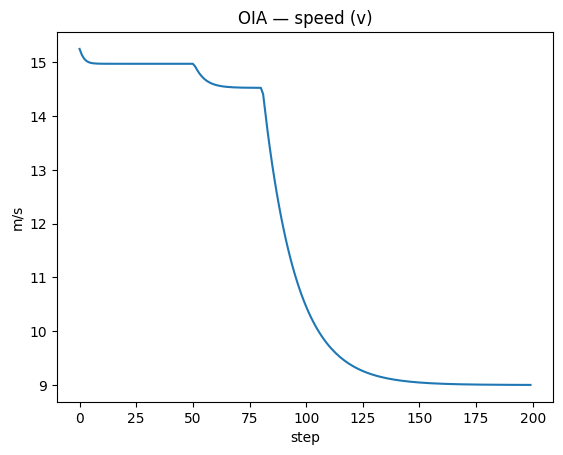

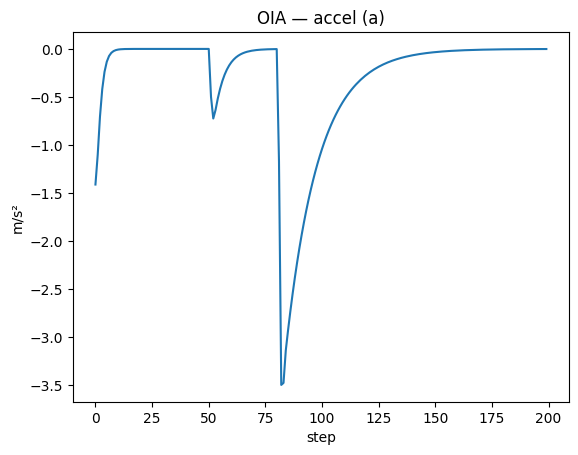

In [30]:
# ---------- plots per paper: return, collisions, jerk ----------
labels = ["Baseline","FGSM","OIA"]
vals_return    = [baseline["avg_return"],    fgsm["avg_return"],    oia["avg_return"]]
vals_collision = [baseline["collision_rate"],fgsm["collision_rate"],oia["collision_rate"]]
vals_jerk      = [baseline["avg_jerk"],      fgsm["avg_jerk"],      oia["avg_jerk"]]

plt.figure(); plt.bar(labels, vals_return);    plt.title("Average Return");     plt.ylabel("return");   plt.show()
plt.figure(); plt.bar(labels, vals_collision); plt.title("Collision Rate");     plt.ylim(0,1);          plt.show()
plt.figure(); plt.bar(labels, vals_jerk);      plt.title("Average Jerk");       plt.ylabel("|Δa|");     plt.show()

# ---------- stealth (RMSE) comparison FGSM vs OIA ----------
def series_mean(x): 
    try: return float(np.nanmean(x)) if x is not None and len(x)>0 else float("nan")
    except: return float("nan")

fgsm_rmse_mean = series_mean(fgsm["sample"]["rmse_series"])
oia_rmse_mean  = series_mean(oia["sample"]["rmse_series"])

plt.figure()
plt.bar(["FGSM","OIA"], [fgsm_rmse_mean, oia_rmse_mean])
plt.title("Stealth (RMSE) — lower is stealthier")
plt.ylabel("RMSE of perturbation per step")
plt.show()

# ---------- trajectory plots (Δx, v, a) to visualize delayed braking under OIA ----------
def plot_traj(traj, title):
    t = np.arange(len(traj["Δx"]))
    plt.figure(); plt.plot(t, traj["Δx"]); plt.xlabel("step"); plt.ylabel("m");    plt.title(title+" — headway (Δx)"); plt.show()
    plt.figure(); plt.plot(t, traj["v"]);   plt.xlabel("step"); plt.ylabel("m/s");  plt.title(title+" — speed (v)");    plt.show()
    plt.figure(); plt.plot(t, traj["a"]);   plt.xlabel("step"); plt.ylabel("m/s²"); plt.title(title+" — accel (a)");    plt.show()

plot_traj(baseline["sample"]["traj"], "Baseline")
plot_traj(fgsm["sample"]["traj"],     "FGSM")
plot_traj(oia["sample"]["traj"],      "OIA")


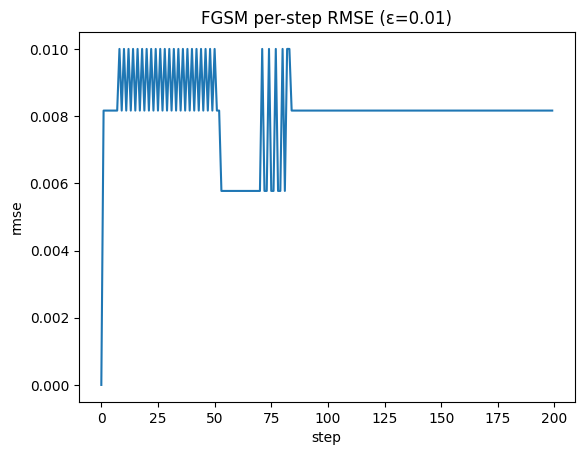

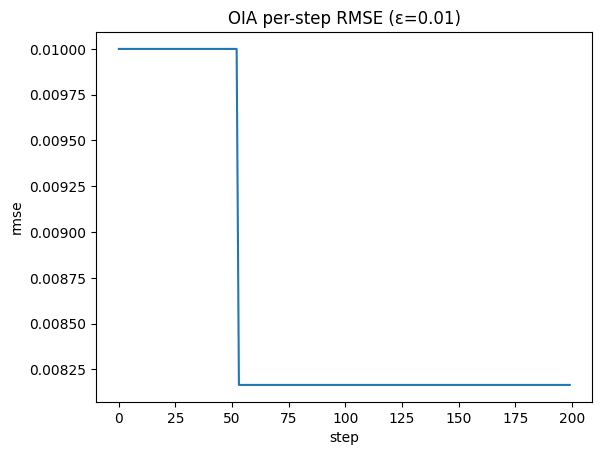

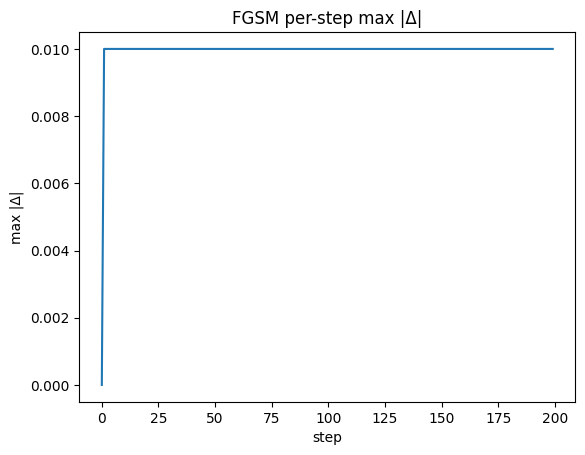

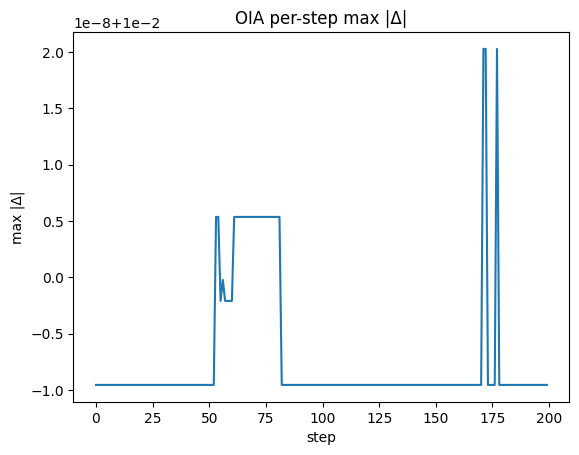

In [31]:
def plot_series(arr, title, ylabel):
    if arr is None or len(arr)==0: 
        print("No data for", title); 
        return
    t = np.arange(len(arr))
    plt.figure(); plt.plot(t, arr); plt.title(title); plt.xlabel("step"); plt.ylabel(ylabel); plt.show()

plot_series(fgsm["sample"]["rmse_series"], f"FGSM per-step RMSE (ε={EPS})", "rmse")
plot_series(oia["sample"]["rmse_series"],  f"OIA per-step RMSE (ε={EPS})",  "rmse")
plot_series(fgsm["sample"]["max_series"],  "FGSM per-step max |Δ|",         "max |Δ|")
plot_series(oia["sample"]["max_series"],   "OIA per-step max |Δ|",          "max |Δ|")